## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Jan 13 01:47:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()
from IPython.display import display, Image

import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/166.8 GB disk)


## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Custom Dataset

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR-API-KEY")
project = rf.workspace("nicolai-hoirup-nielsen").project("cupsegmentation")
dataset = project.version(2).download("yolov5-obb")

/content/datasets
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing in

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CupSegmentation-2 in yolov5-obb:: 100%|██████████| 730/730 [00:00<00:00, 7650.84it/s]


In [ ]:
import os

# Define the classes and their corresponding indices
class_names = ['Cocio-Cup', 'Cup', 'Halloween-Cup', 'Hand-Painted-Cup', 'White-Cup']
class_indices = {name: index for index, name in enumerate(class_names)}


# Image dimensions
img_width, img_height = 640, 640

# Path to the folder containing the annotation files
folder_path = '/content/datasets/CupSegmentation-2/train/labels'

# Function to normalize coordinates
def normalize_coordinates(coord, max_value):
    return float(coord) / max_value

# Process each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):  # assuming the annotation files are .txt files
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            lines = file.readlines()


        new_lines = []
        for line in lines:
            parts = line.strip().split(' ')
            if len(parts) == 10:
                # Extract label and coordinates
                label = parts[-2]
                coords = parts[:8]

                # Get the class index
                class_index = class_indices.get(label, -1)
                if class_index != -1:
                    # Normalize coordinates
                    normalized_coords = [normalize_coordinates(coords[i], img_width if i % 2 == 0 else img_height) for i in range(8)]

                    # Convert to the desired format and add to new lines
                    new_line = f"{class_index} " + " ".join(map(str, normalized_coords))
                    new_lines.append(new_line)

        # Write the converted lines to a new file or overwrite the existing file
        with open(file_path, 'w') as file:
            file.write('\n'.join(new_lines))

## Custom Training

In [ ]:
%cd {HOME}

!yolo task=obb mode=train model=yolov8s-obb.pt data={dataset.location}/data.yaml epochs=35 imgsz=640 batch=8

/content
100% 22.2M/22.2M [00:00<00:00, 157MB/s]
Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=obb, mode=train, model=yolov8s-obb.pt, data=/content/datasets/CupSegmentation-2/data.yaml, epochs=35, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/obb/train/confusion_matrix.png', width=600)

/content


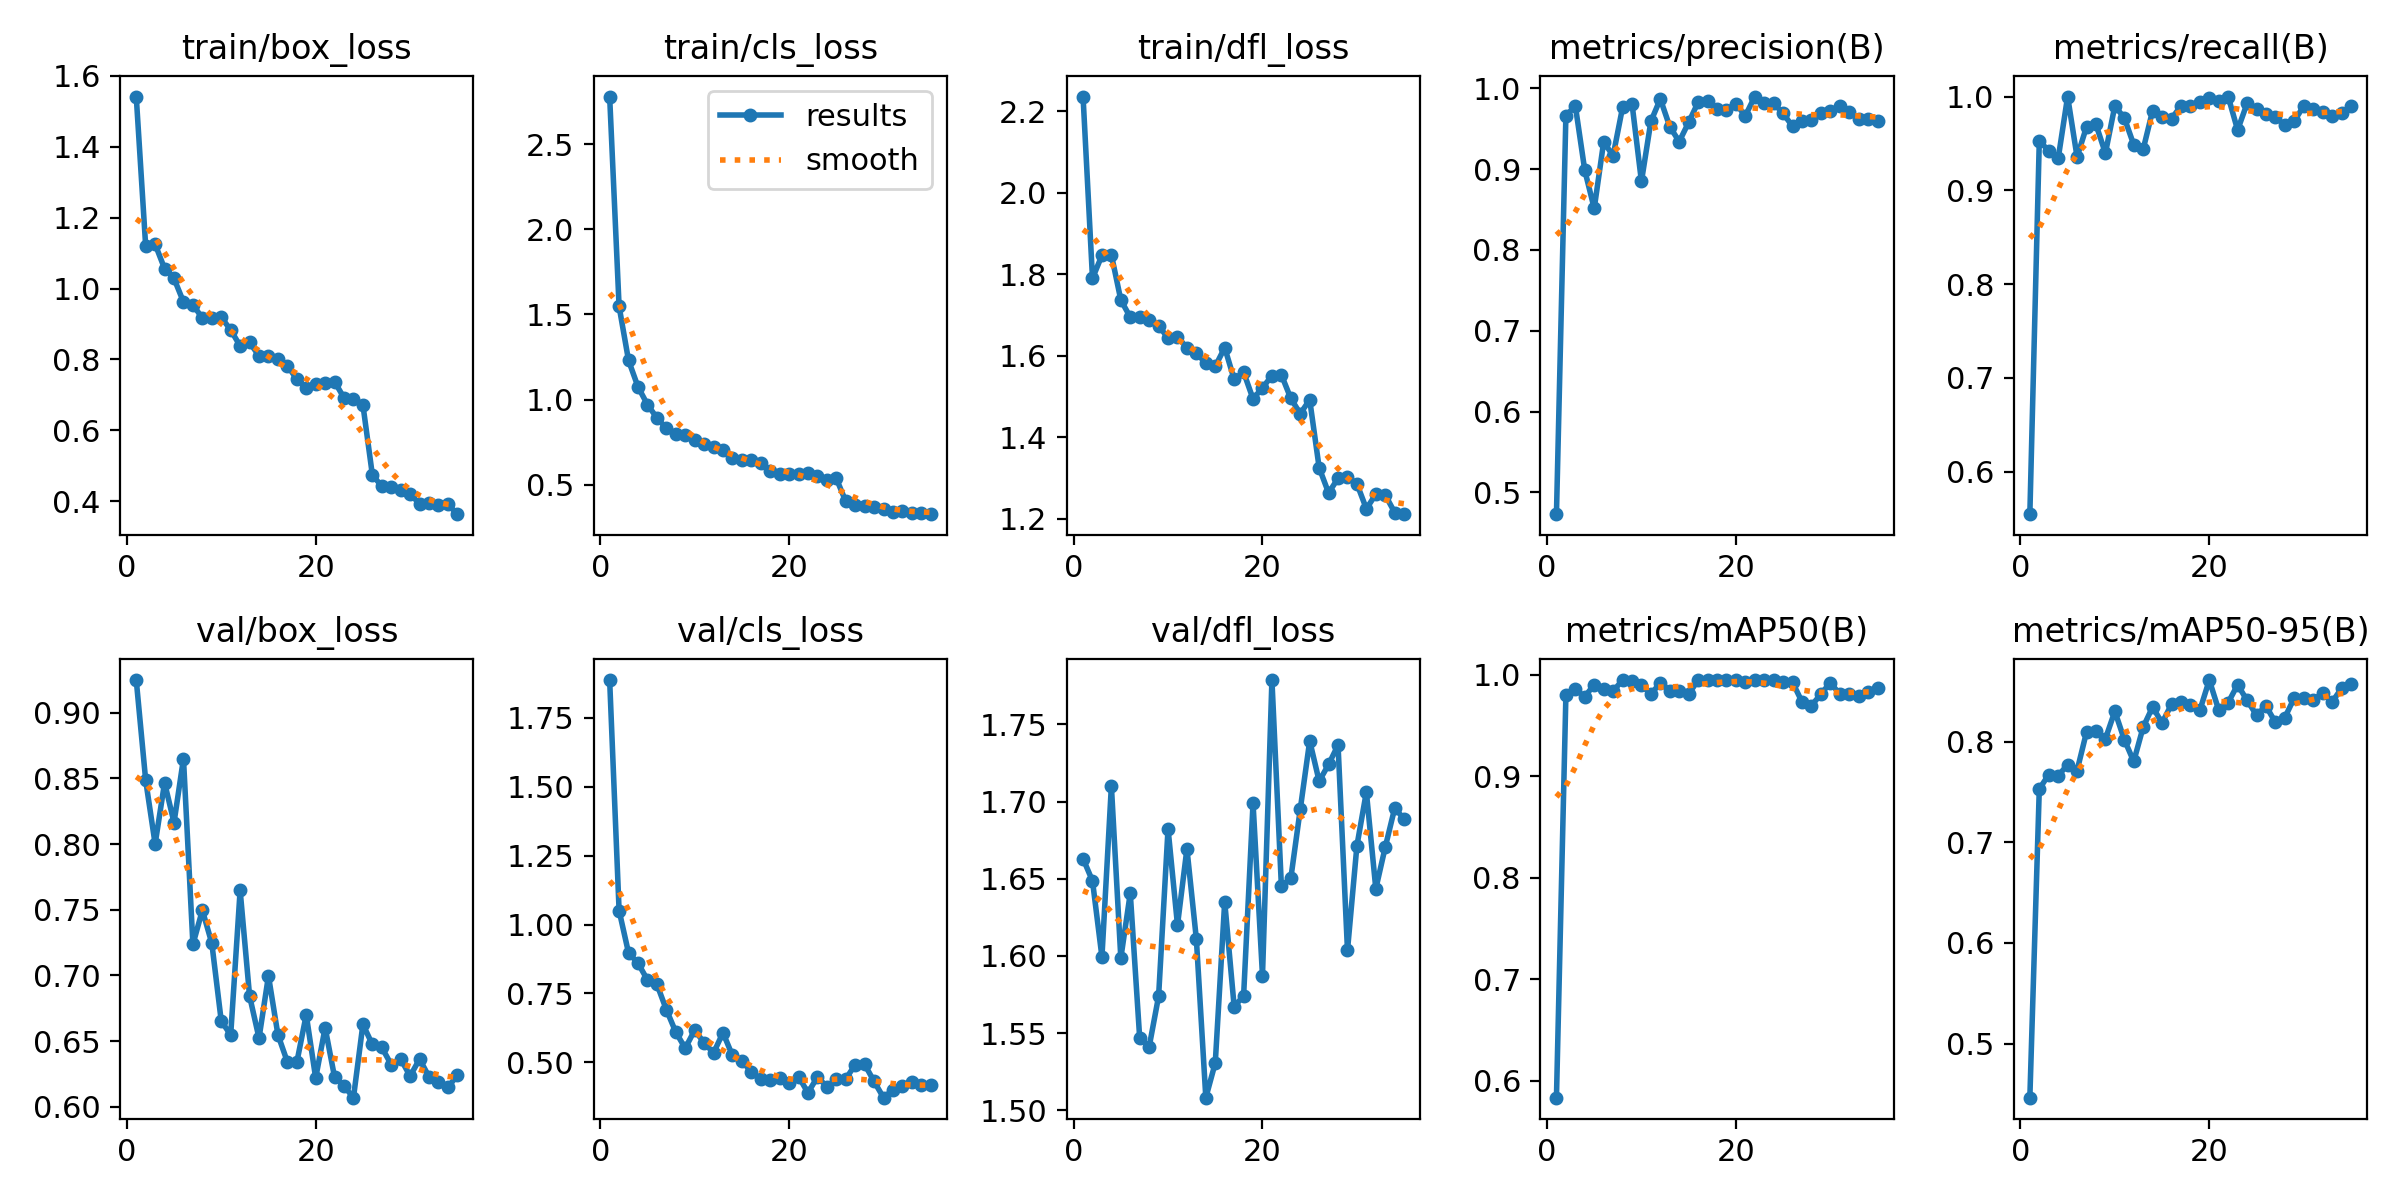

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/obb/train/results.png', width=600)

/content


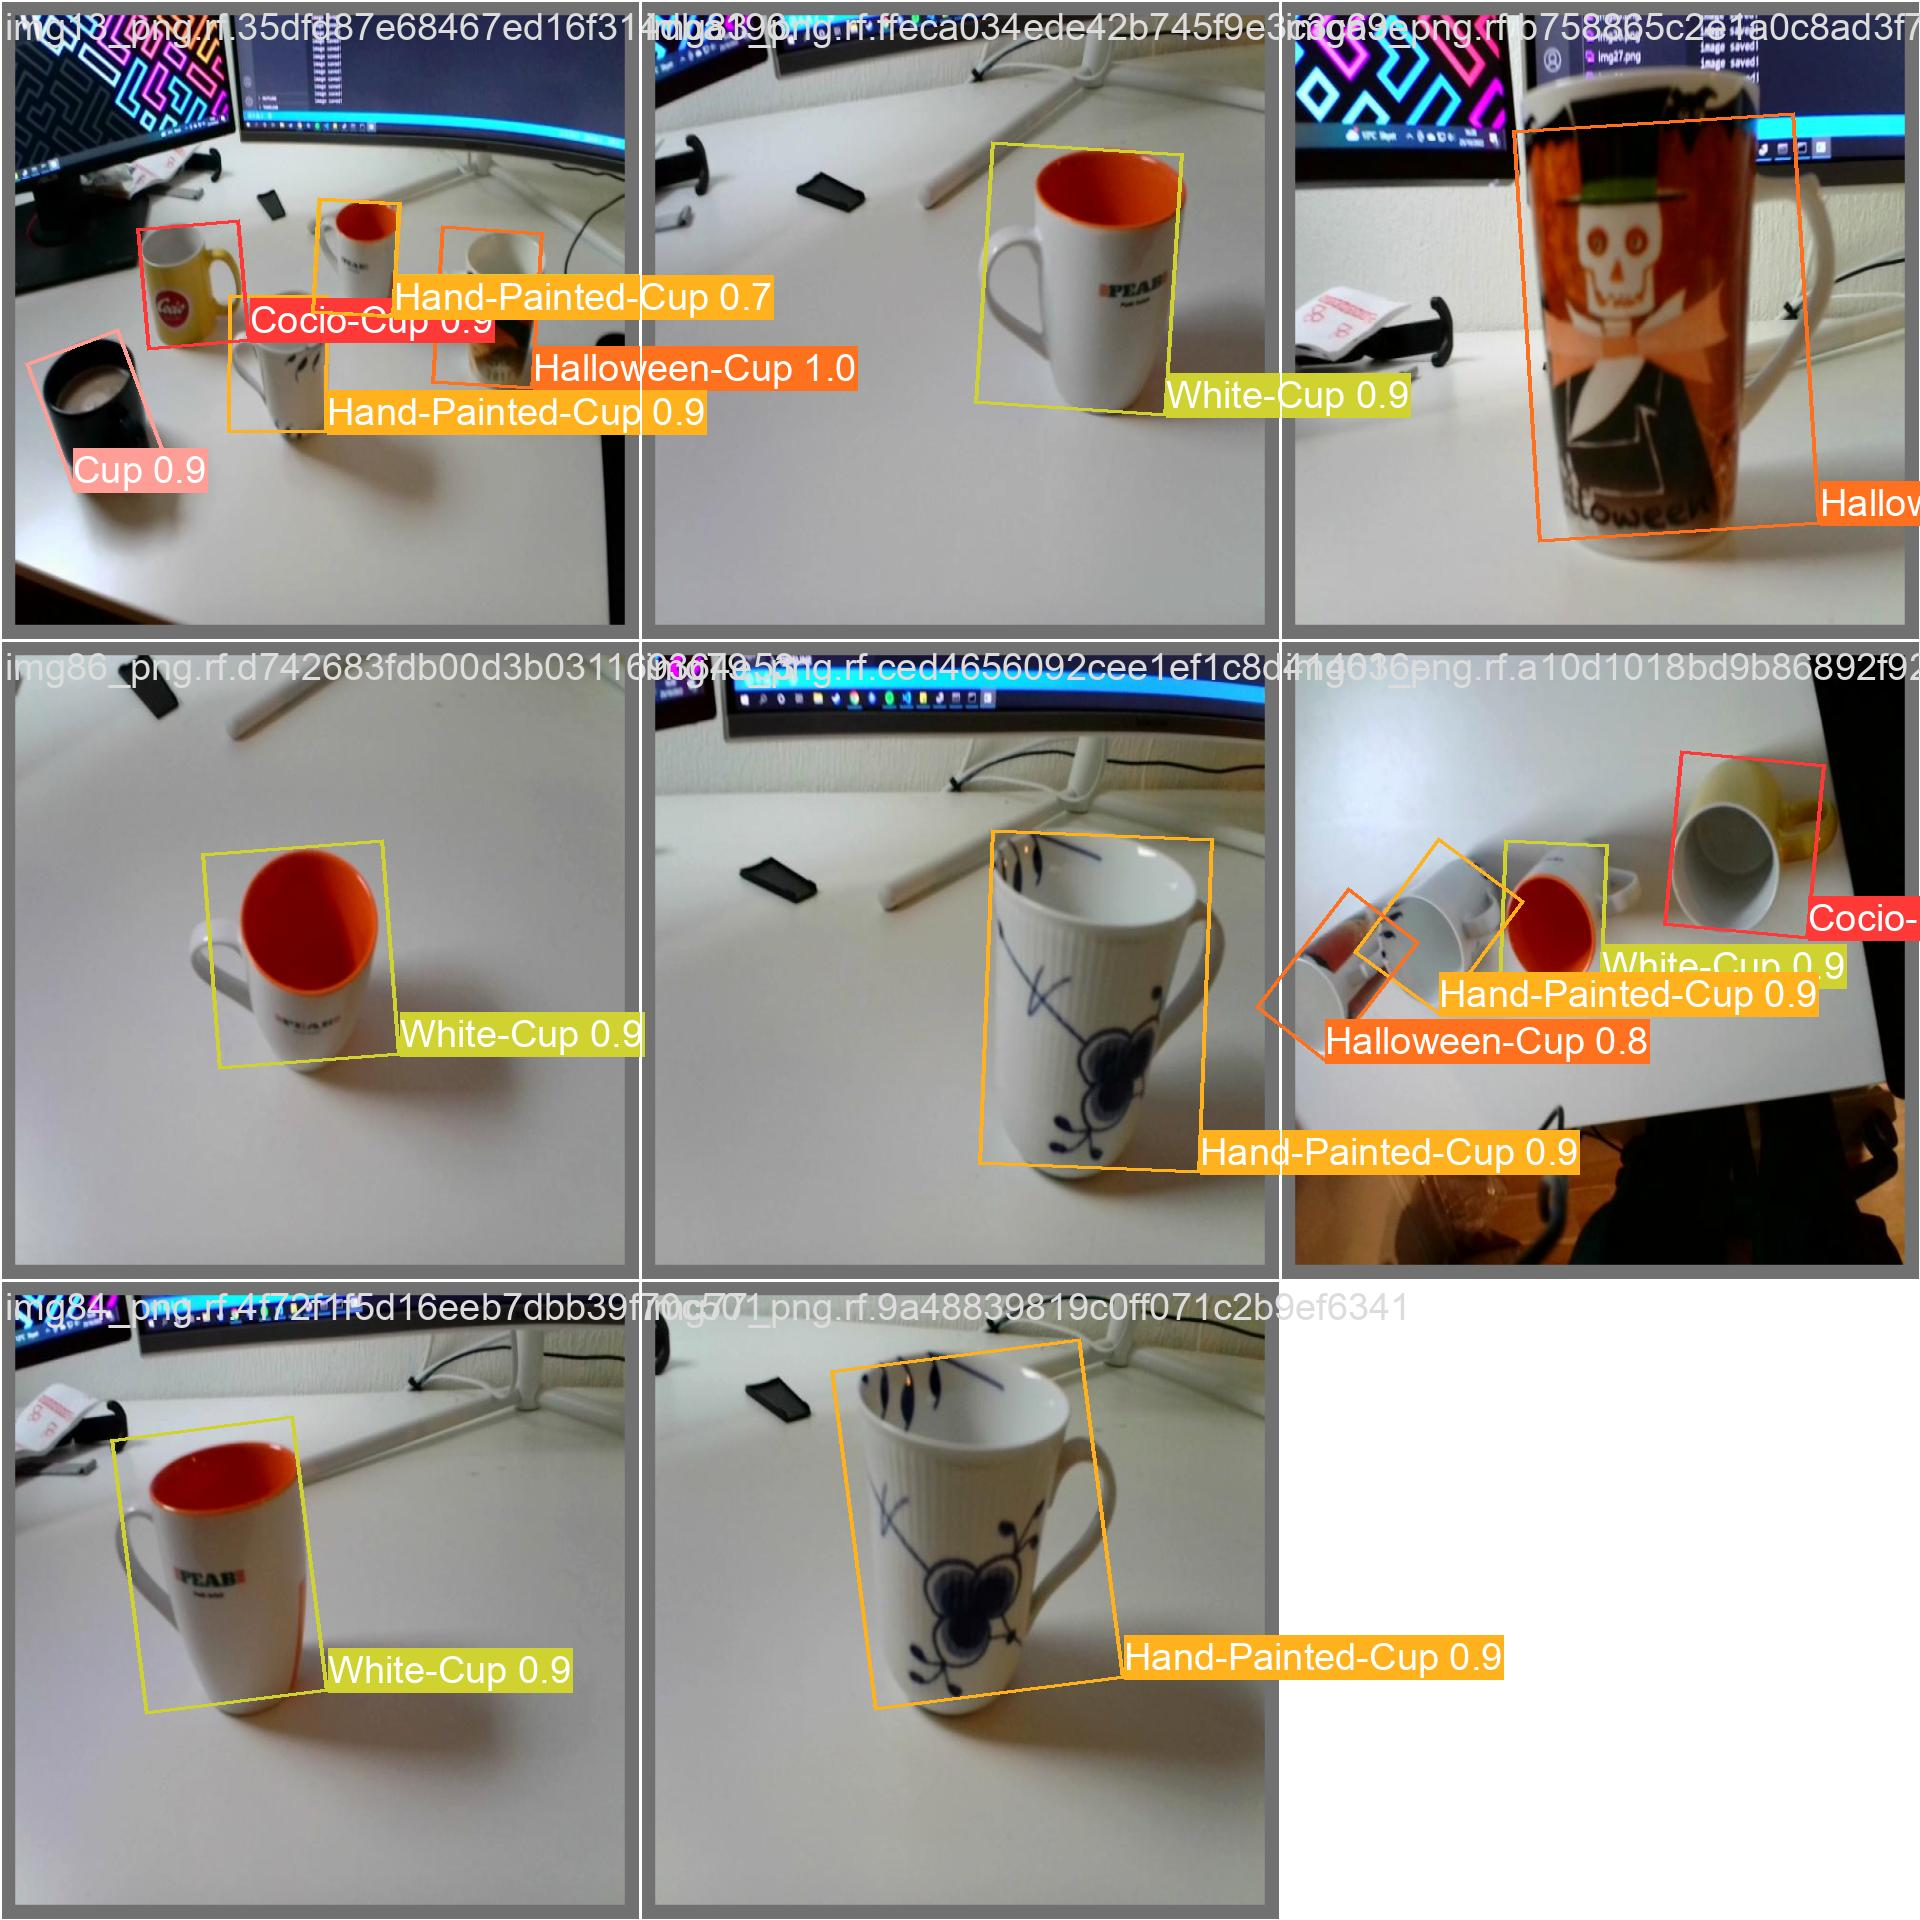

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/obb/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=obb mode=val model={HOME}/runs/obb/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-obb summary (fused): 187 layers, 11413506 parameters, 0 gradients, 29.4 GFLOPs
val: Scanning /content/datasets/CupSegmentation-2/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100% 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.13it/s]
                   all         19         58       0.98      0.998      0.995      0.861
             Cocio-Cup         19         13      0.985          1      0.995      0.886
                   Cup         19          6      0.977          1      0.995      0.933
         Halloween-Cup         19         12      0.995          1      0.995      0.775
      Hand-Painted-Cup         19         13      0.943          1      0.995      0.898
             White-Cup         19         14          1      0.989      0.995      0.815
Speed: 0.2ms preprocess

## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=obb mode=predict model={HOME}/runs/obb/train/weights/best.pt conf=0.5 source={dataset.location}/test/images save=true

/content
Ultralytics YOLOv8.1.1 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-obb summary (fused): 187 layers, 11413506 parameters, 0 gradients, 29.4 GFLOPs

image 1/10 /content/datasets/CupSegmentation-2/test/images/img20_png.rf.408df4da906e6f9863b3ffafc9029e2e.jpg: 640x640 17.3ms
image 2/10 /content/datasets/CupSegmentation-2/test/images/img21_png.rf.bce2432e4094ed021dbfa966e295ff17.jpg: 640x640 17.4ms
image 3/10 /content/datasets/CupSegmentation-2/test/images/img27_png.rf.5e54ffee498241dfffaff51671499c88.jpg: 640x640 17.3ms
image 4/10 /content/datasets/CupSegmentation-2/test/images/img28_png.rf.5a812284768c60162cbb53146f4668ad.jpg: 640x640 17.3ms
image 5/10 /content/datasets/CupSegmentation-2/test/images/img44_png.rf.497bc1907f262012eb5b68f749ac7df4.jpg: 640x640 17.3ms
image 6/10 /content/datasets/CupSegmentation-2/test/images/img52_png.rf.faa4a028a3c6f6030c71ad4d879f1c6c.jpg: 640x640 17.3ms
image 7/10 /content/datasets/CupSegmentation-2/test/images/img55_pn

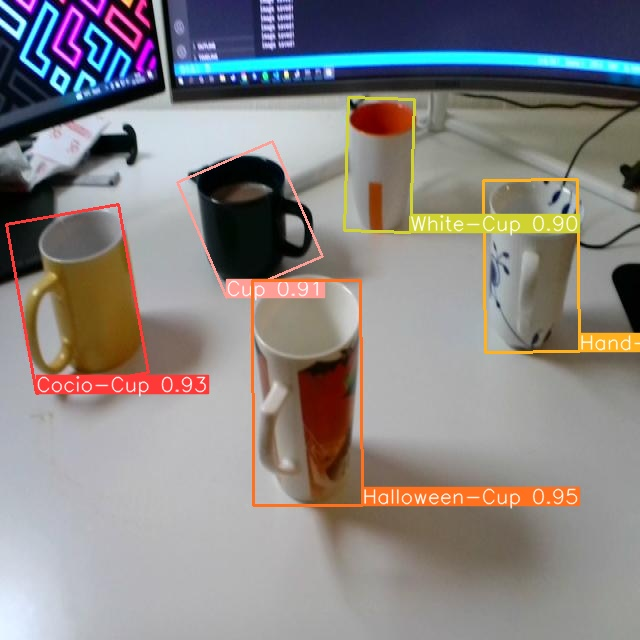

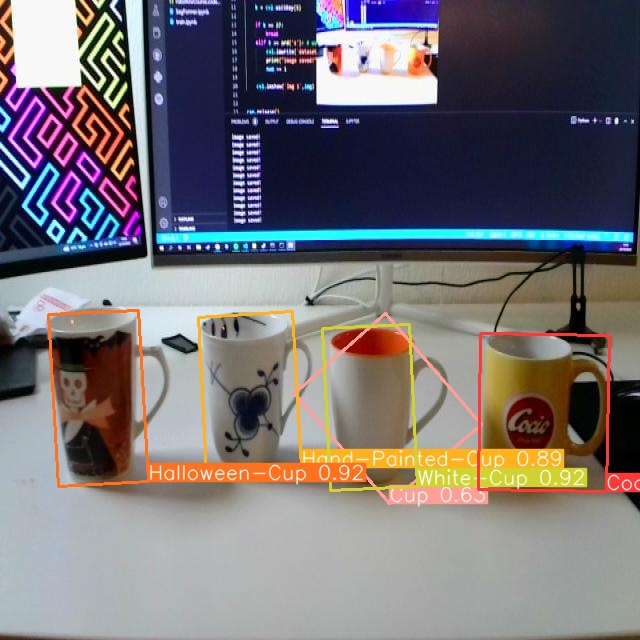

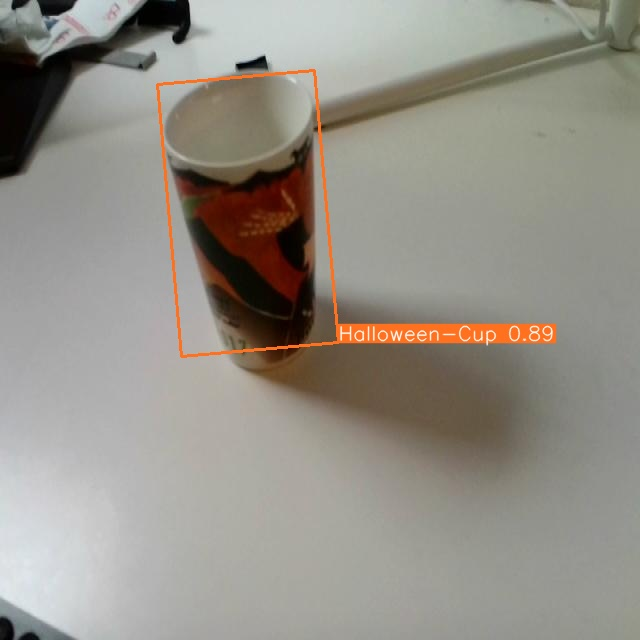

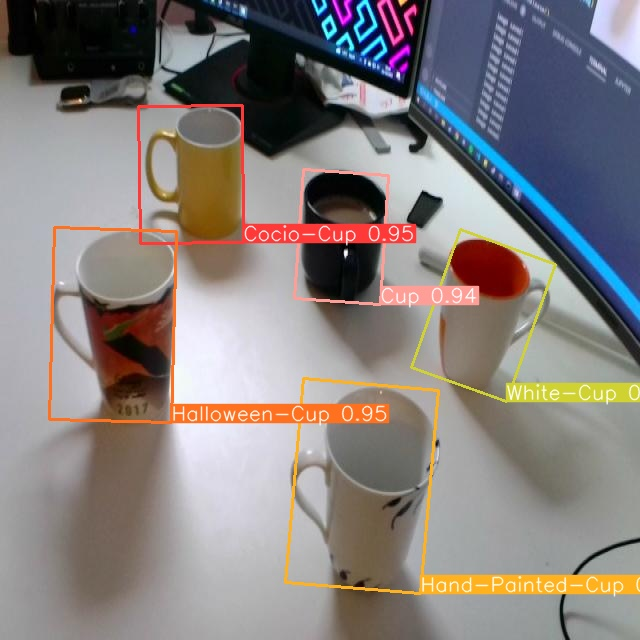

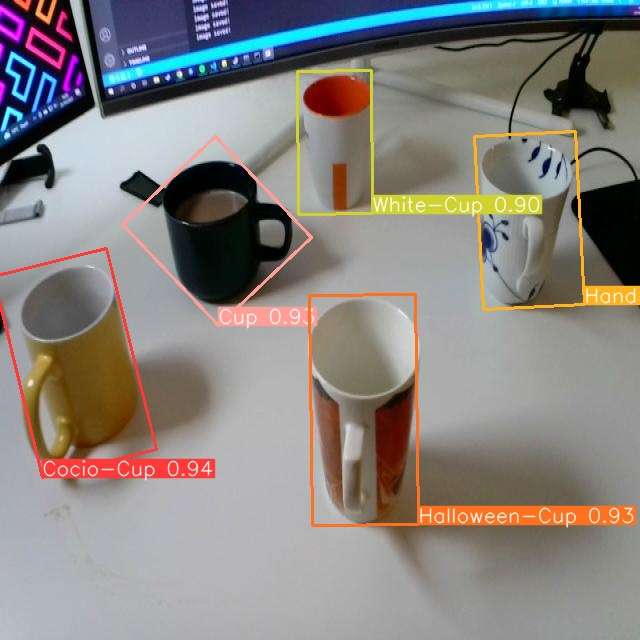

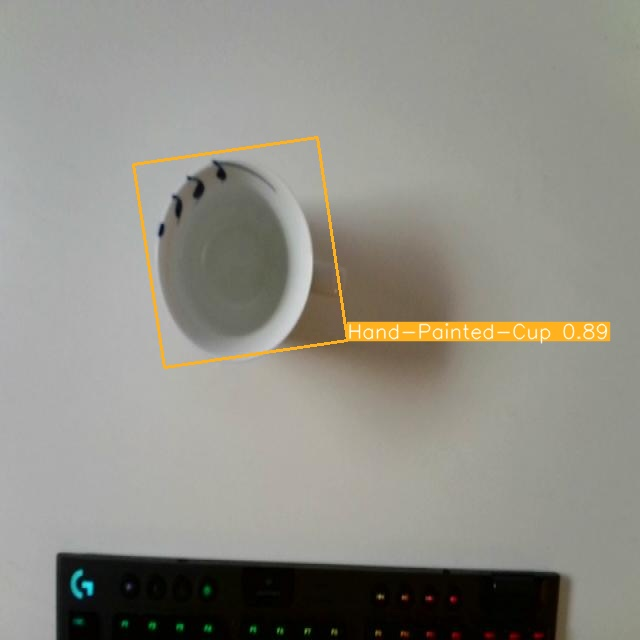

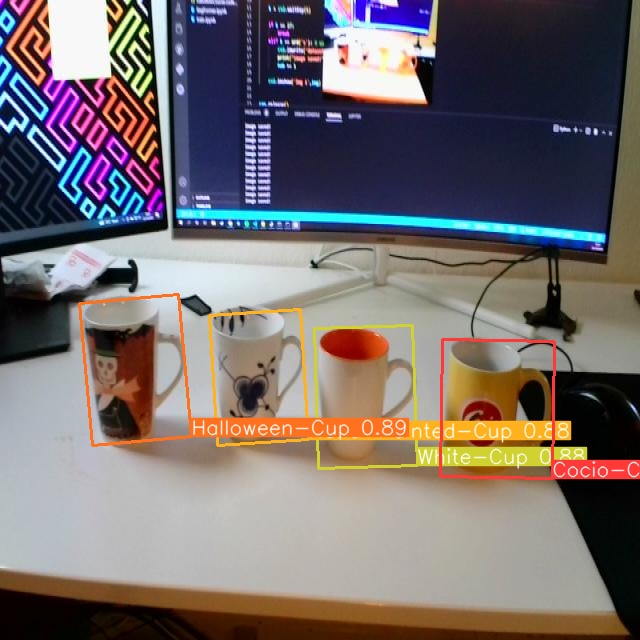

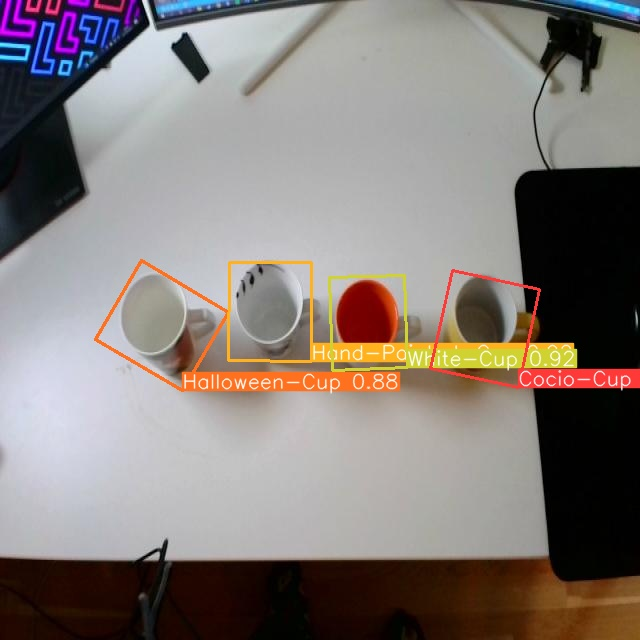

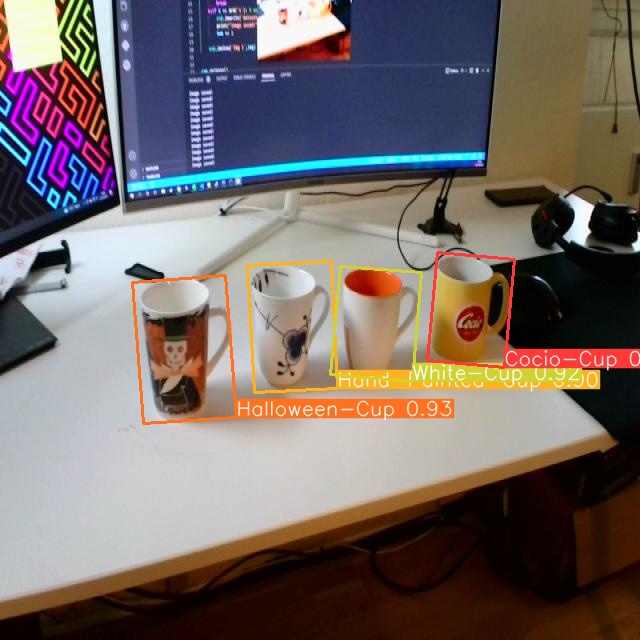

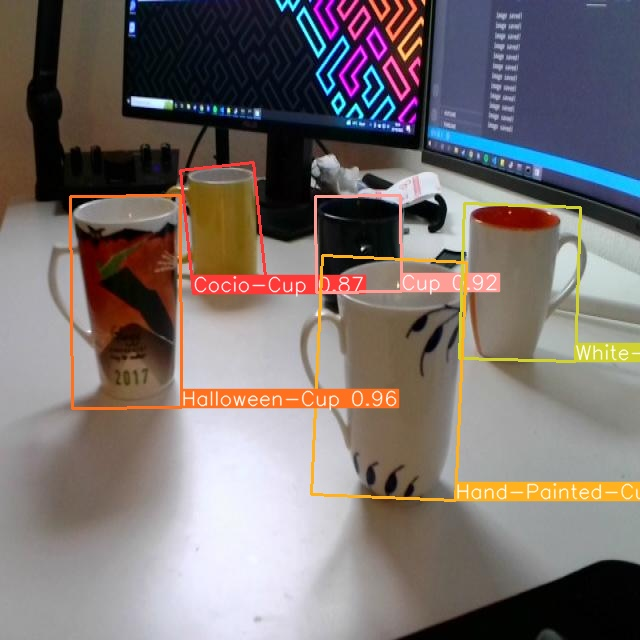

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/obb/predict/*.jpg'):
      display(Image(filename=image_path, height=600))
      print("\n")